# training_demonstration.ipynb
## Author: Connacher Murphy

Demonstrates training with smooth check loss.

To do:
1. Save output (turn into `.py` script)
1. Break symmetry

## 0. Load required libraries

In [158]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import quantile_dnn as qdnn

## 1. DGP
Consider a generic data generating process:
$$
    Y = \mathbb{Q}_{U}[Y | X], \text{ where } U \sim \text{Unif}[0,1].
$$

In this notebook, I let $U, X \sim \text{Unif}[0,1]$ and $\mathbb{Q}_{u}[Y | X = x] = u \times x$.

Accordingly, $\mathbb{E}[Y | X = x] = 0.5 x$.

In [159]:
torch.manual_seed(12345)  # Set the seed for reproducibility

N = 15000  # observation count
K = 1  # feature count

# Draw independent features from a uniform distribution and multiply by 5
dnn_feature = torch.rand(N, K)

# Idiosyncratic error under quantile DGP
U = torch.rand(N, 1)

# Calculate outcomes
outcomes = torch.mul(dnn_feature, U)

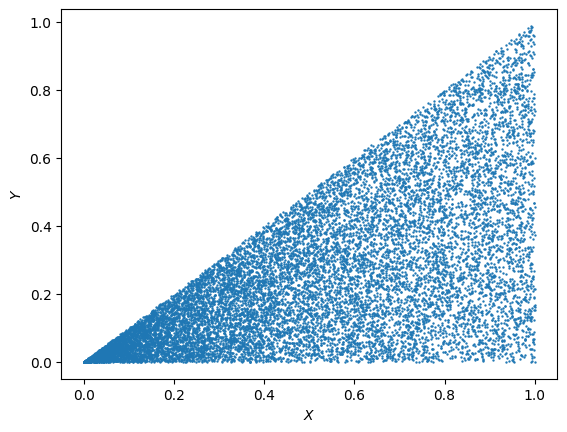

In [160]:
# Plot outcomes against features
plt.scatter(dnn_feature, outcomes, s = 0.5)
plt.xlabel("$X$")
plt.ylabel("$Y$")
plt.show()

## 2. Training tools

In [161]:
# Create a class for a DNN with ReLU activation, dropout layers, and Kaiming initialization
class DeepNeuralNetworkReLU(nn.Module):
    def __init__(self, input_dim, hidden_sizes, output_dim, dropout_rate):
        super(DeepNeuralNetworkReLU, self).__init__()
        self.layers = nn.ModuleList()
        prev_size = input_dim
        for hidden_size in hidden_sizes:
            linear = nn.Linear(prev_size, hidden_size)
            nn.init.kaiming_normal_(linear.weight, mode="fan_in")
            self.layers.append(linear)
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        self.layers.append(nn.Linear(prev_size, output_dim))

    # Define the forward pass
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

## 3. Common hyperparameters

In [162]:
# Hyperparameters
num_epochs = 1000
hidden_sizes = [64, 64]
output_dim = outcomes.shape[1]
dropout_rate = 0.0
learning_rate = 1e-3
weight_decay = 0.0

In [163]:
# Plotting objects
dnn_feature_plot = np.linspace(0, 1, 101)
dnn_feature_plot_tensor = torch.tensor(dnn_feature_plot).reshape(-1, 1).float()

## 4. Training with MSE

In [164]:
# Initialize the model
model = DeepNeuralNetworkReLU(
    input_dim=K,
    hidden_sizes=hidden_sizes,
    output_dim=output_dim,
    dropout_rate=dropout_rate,
)

In [165]:
# Use MSE loss
loss_fn = nn.MSELoss()

In [166]:
# Initialize the optimizer
optimizer = optim.SGD(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)

In [167]:
# Store the loss history
loss_history = []

for epoch in tqdm(range(num_epochs)):
    # Forward pass
    outcomes_pred = model(dnn_feature)

    # Calculate the loss
    loss = loss_fn(outcomes_pred, outcomes)
    if np.isnan(float(loss)):
        print("NaN loss detected :(")
        print(loss)
        break

    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

    # Store loss
    loss_history.append(loss.item())

outcomes_pred = model(dnn_feature)

100%|██████████| 1000/1000 [00:04<00:00, 225.79it/s]


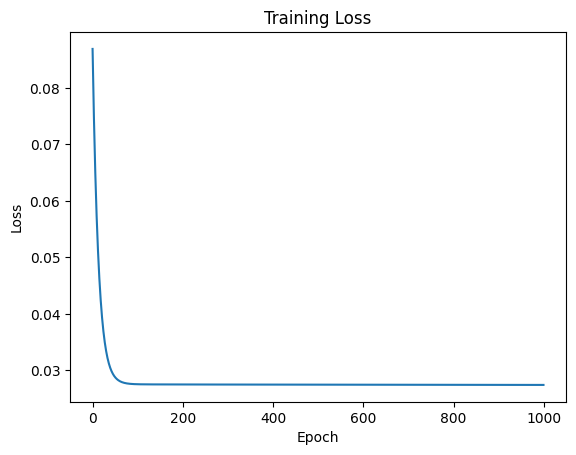

In [168]:
# Loss history
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [169]:
# Obtain model predictions on plotting feature tensor
output_plot_tensor = model(dnn_feature_plot_tensor)
output_plot = output_plot_tensor.detach().numpy()

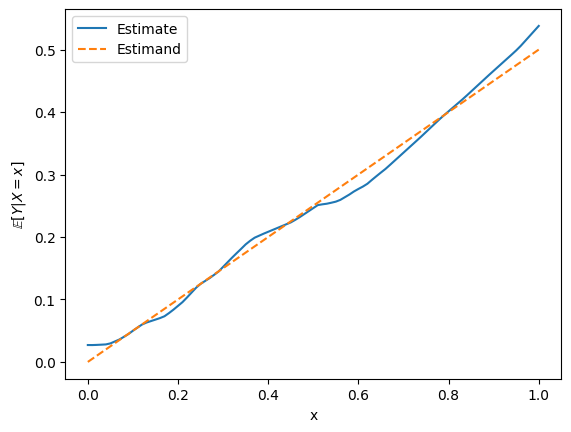

In [170]:
# Expected value: E[Y|X=x] = 0.5X
E = dnn_feature_plot * 0.5

# Plot
plt.plot(dnn_feature_plot, output_plot, label = "Estimate")
plt.plot(dnn_feature_plot, E, linestyle="--", label = "Estimand")
plt.xlabel("x")
plt.ylabel("$\mathbb{E}[Y|X=x]$")
plt.legend()
plt.show()

## 5. Training with smooth check loss

In [181]:
quantiles = [0.25, 0.5, 0.75]

Quantile: 0.25


100%|██████████| 1000/1000 [00:05<00:00, 195.50it/s]


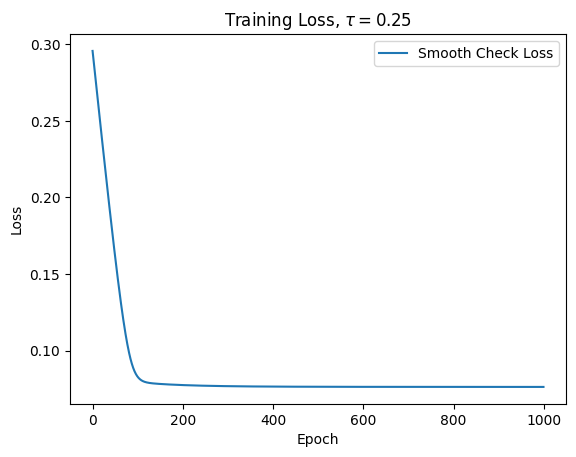

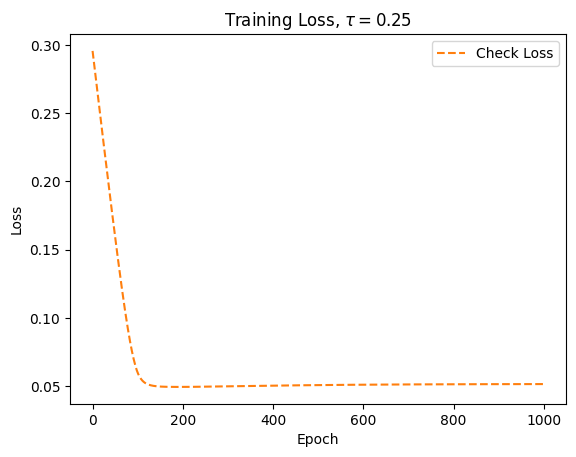

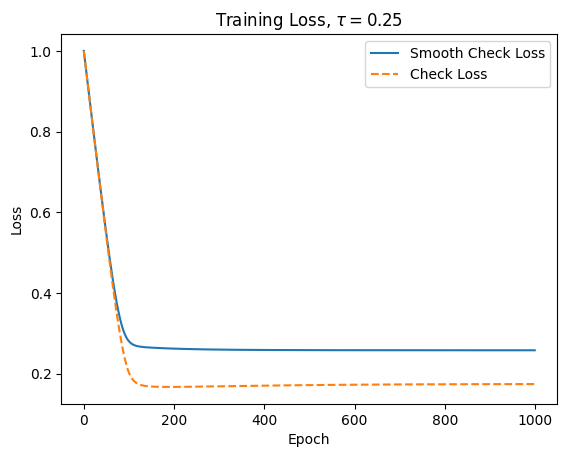

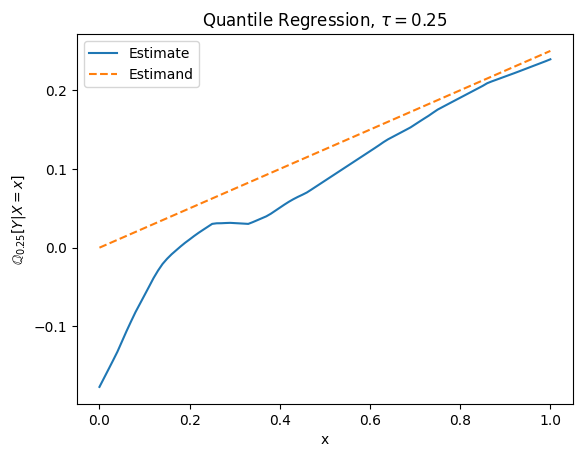

Quantile: 0.5


100%|██████████| 1000/1000 [00:05<00:00, 198.15it/s]


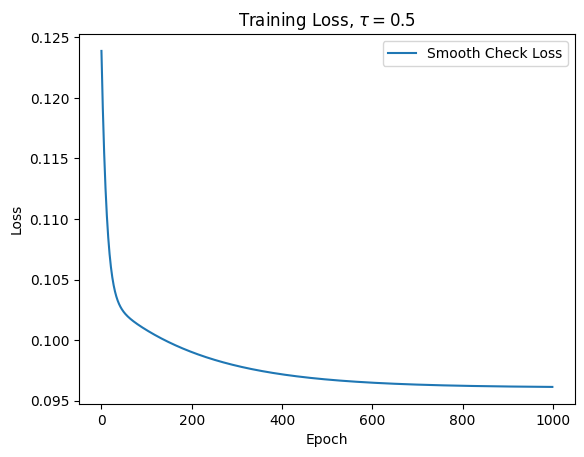

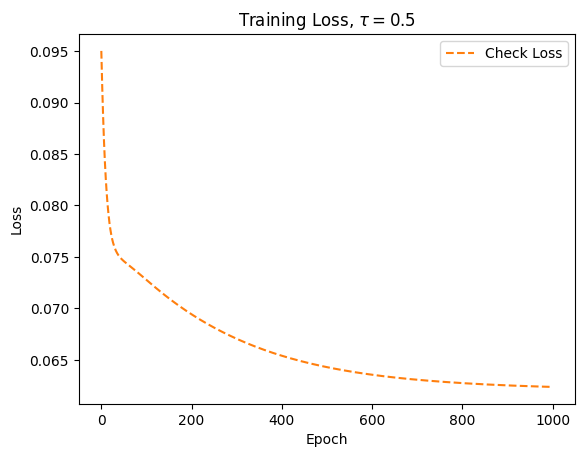

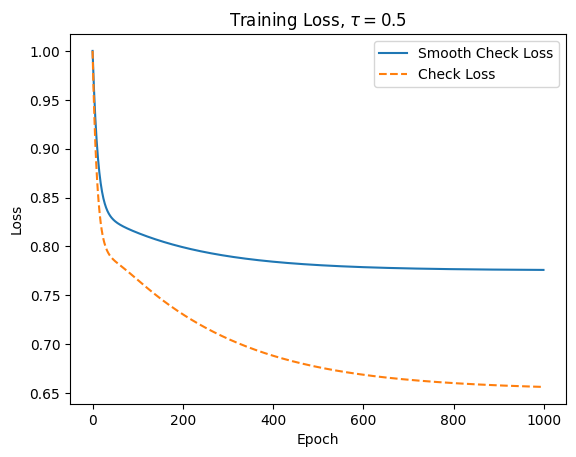

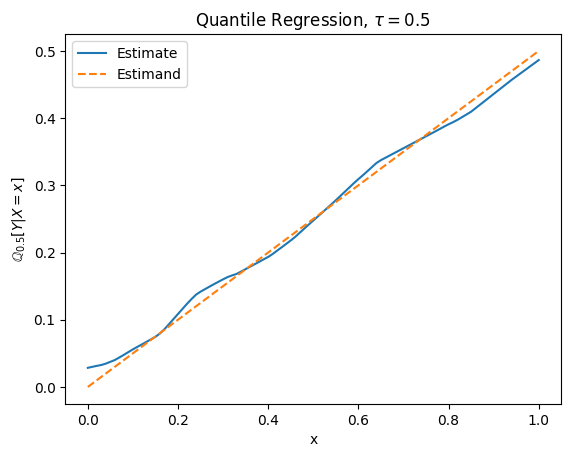

Quantile: 0.75


100%|██████████| 1000/1000 [00:05<00:00, 199.98it/s]


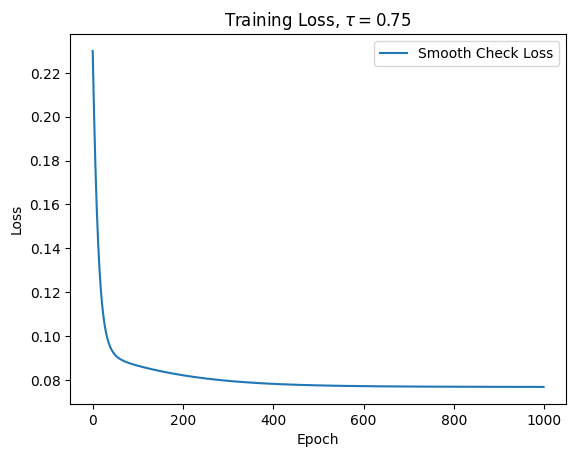

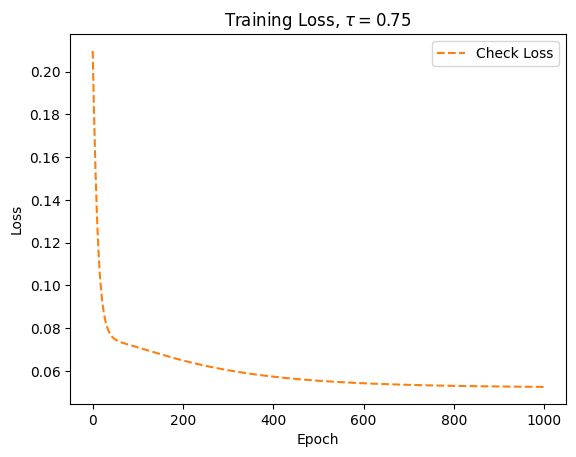

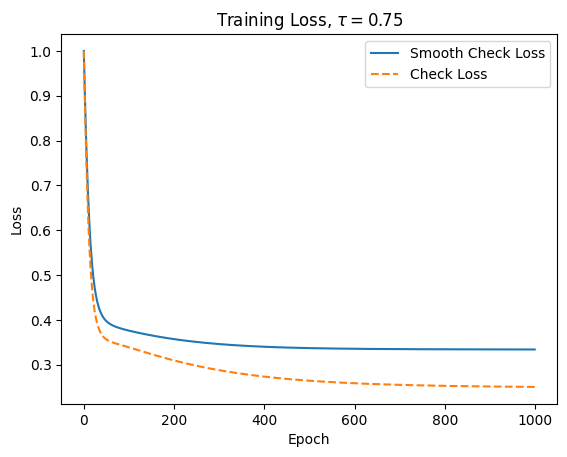

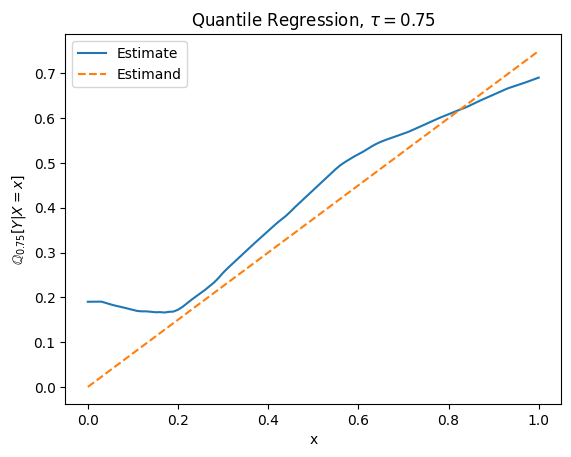

In [186]:
for tau in quantiles:
    print("Quantile:", tau)

    # Initialize the model
    model = DeepNeuralNetworkReLU(
        input_dim=K,
        hidden_sizes=hidden_sizes,
        output_dim=output_dim,
        dropout_rate=dropout_rate,
    )

    # Use smooth check loss
    alpha = 0.1

    loss_fn = qdnn.SmoothCheckLoss(tau, alpha, reduction="mean")

    loss_fn_check = qdnn.CheckLoss(tau, reduction="mean")

    # Initialize the optimizer
    optimizer = optim.SGD(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )

    # Store the loss history
    loss_history = []
    loss_check_history = []

    for epoch in tqdm(range(num_epochs)):
        # Forward pass
        outcomes_pred = model(dnn_feature)

        # Calculate the loss
        loss = loss_fn(outcomes_pred, outcomes)

        if np.isnan(float(loss)):
                print("NaN loss detected :(")
                print(loss)
                break

        # Calculate check loss
        with torch.no_grad():
            loss_check = loss_fn_check(outcomes_pred, outcomes)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update parameters
        optimizer.step()

        # Store loss
        loss_history.append(loss.item())
        loss_check_history.append(loss_check.item())

    outcomes_pred = model(dnn_feature)

    plt.plot(loss_history, label="Smooth Check Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training Loss, $\\tau = {tau}$")
    plt.legend()
    plt.show()

    plt.plot(loss_check_history, label="Check Loss", linestyle="--", color="tab:orange")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training Loss, $\\tau = {tau}$")
    plt.legend()
    plt.show()

    plt.plot([loss / loss_history[0] for loss in loss_history], label="Smooth Check Loss")
    plt.plot([loss_check / loss_check_history[0] for loss_check in loss_check_history], label="Check Loss", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training Loss, $\\tau = {tau}$")
    plt.legend()
    plt.show()

    # Obtain model predictions on plotting feature tensor
    output_plot_tensor = model(dnn_feature_plot_tensor)
    output_plot = output_plot_tensor.detach().numpy()

    # Conditional quantile: Q_(u)[Y|X=x] = u * x
    Q = dnn_feature_plot * tau

    # Plot
    plt.plot(dnn_feature_plot, output_plot, label = "Estimate")
    plt.plot(dnn_feature_plot, Q, linestyle="--", label = "Estimand")
    plt.xlabel("x")
    plt.ylabel(f"$\mathbb{{Q}}_{{{tau}}}[Y|X=x]$")
    plt.title(f"Quantile Regression, $\\tau = {tau}$")
    plt.legend()
    plt.show()
